# Seeking for the best model

The objective is to identify the most effective model possible. To achieve this, Principal Component Analysis (PCA) will be applied to our data. Additionally, a grid search for hyperparameters will be conducted  multiple times during training and validation steps to find a nice model. Analisys of performing transformations at the target variable is also conducted.

The penalty cost associated with this approach will be calculated.

Furthermore, the generated models will be saved for future use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import time
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.ensemble import VotingRegressor
import pickle
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
import gc

In [2]:
def get_loss(y_test, y_pred, show=True):
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean squared error: {mse:.4f}')
    
    
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f'Root mean squared error: {rmse:.4f}')
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae}")
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2:.4f}')
    
    if show:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
        plt.title('Predictions vs Real Values')
        plt.xlabel('Real Values')
        plt.ylabel('Predictions')
        plt.grid()
        plt.show()
    return mse, rmse, r2, mae

In [3]:
df = pd.read_csv('EDA-Fase3.csv')
df.head()

,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,...,Prefecture_shizuoka prefecture,Prefecture_tochigi prefecture,Prefecture_tokushima prefecture,Prefecture_tokyo,Prefecture_tottori prefecture,Prefecture_toyama prefecture,Prefecture_wakayama prefecture,Prefecture_yamagata prefecture,Prefecture_yamaguchi prefecture,Prefecture_yamanashi prefecture
0,15.00000,15.00000,50000000,330,False,150000.000000,19.5,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0
1,29.87038,29.87038,32000000,200,False,157124.851993,NaN,False,120.0,False,...,0,0,0,0,0,0,0,0,0,0
2,16.00000,16.00000,37000000,180,False,201861.789019,13.4,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
3,5.00000,5.00000,35000000,190,False,180900.323019,12.0,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
4,120.00000,120.00000,380000,195,False,1900.000000,17.4,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0


In [4]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols

Index(['Municipality_M', 'Municipality_ci_name', 'Municipality_co_name'], dtype='object')

In [5]:
for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(col + ": ",len(df[col].unique()))
    print(df[col].value_counts(dropna=False).to_string())
print(df[categorical_cols].info())

#As the trees only acept a max of 255 (for AUTO) number of different categories this data cannot be used for training
df.drop(columns=categorical_cols, inplace=True)

Municipality_M:  1655
Municipality_M
chuo                 69248
kita                 65424
minami               62342
nishi                53543
higashi              38778
naka                 30498
ota                  28573
midori               27897
setagaya             26167
kanazawa             22702
nerima               21972
aoba                 21780
adachi               18381
izumi                18342
suginami             17734
minato               17517
funabashi            17436
kawaguchi            16142
utsunomiya           15986
kagoshima            15857
itabashi             15807
himeji               15330
hachioji             14959
gifu                 14694
toyama               14429
koto                 14345
konan                14233
edogawa              14229
matsuyama            13986
asahi                13971
shinjuku             13767
shinagawa            13338
matsudo              12902
nishinomiya          12758
fujisawa             12745
katsushika        

In [6]:
df = df.sort_values(by=['Year', 'Quarter'])
# to avoid [LightGBM] [Fatal] Do not support special JSON characters in feature name.
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [7]:
#new_index = [[old_index, year, quarter] for old_index, year, quarter in zip(df.index, df['Year'], df['Quarter'])]

In [8]:
df['index_new'] = df.apply(lambda x: [x.name, x['Year'], x['Quarter']], axis=1)

In [9]:
df.set_index('index_new', inplace=True)

In [10]:
df.columns

Index(['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'TradePrice',
       'Area', 'AreaIsGreaterFlag', 'UnitPrice', 'Frontage',
       'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag',
       ...
       'Prefecture_shizuokaprefecture', 'Prefecture_tochigiprefecture',
       'Prefecture_tokushimaprefecture', 'Prefecture_tokyo',
       'Prefecture_tottoriprefecture', 'Prefecture_toyamaprefecture',
       'Prefecture_wakayamaprefecture', 'Prefecture_yamagataprefecture',
       'Prefecture_yamaguchiprefecture', 'Prefecture_yamanashiprefecture'],
      dtype='object', length=164)

In [11]:
df.head()

,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,...,Prefecture_shizuokaprefecture,Prefecture_tochigiprefecture,Prefecture_tokushimaprefecture,Prefecture_tokyo,Prefecture_tottoriprefecture,Prefecture_toyamaprefecture,Prefecture_wakayamaprefecture,Prefecture_yamagataprefecture,Prefecture_yamaguchiprefecture,Prefecture_yamanashiprefecture
index_new,,,,,,,,,,,,,,,,,,,,,
"[0, 2005, 3]",15.00000,15.00000,50000000,330,False,150000.000000,19.5,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0
"[1, 2005, 3]",29.87038,29.87038,32000000,200,False,157124.851993,NaN,False,120.0,False,...,0,0,0,0,0,0,0,0,0,0
"[2, 2005, 3]",16.00000,16.00000,37000000,180,False,201861.789019,13.4,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
"[3, 2005, 3]",5.00000,5.00000,35000000,190,False,180900.323019,12.0,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
"[4, 2005, 3]",120.00000,120.00000,380000,195,False,1900.000000,17.4,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print(df.isnull().sum().to_string())

MinTimeToNearestStation                                       0
MaxTimeToNearestStation                                       0
TradePrice                                                    0
Area                                                          0
AreaIsGreaterFlag                                             0
UnitPrice                                                     0
Frontage                                                1353881
FrontageIsGreaterFlag                                         0
TotalFloorArea                                          2570280
TotalFloorAreaIsGreaterFlag                                   0
BuildingYear                                                  0
PrewarBuilding                                                0
Breadth                                                 1205286
CoverageRatio                                            706346
FloorAreaRatio                                           706346
Year                                    

In [13]:
# TO use PCA
df.fillna(df.mean(), inplace=True)

In [14]:
print(df.isnull().sum().to_string())

MinTimeToNearestStation                                 0
MaxTimeToNearestStation                                 0
TradePrice                                              0
Area                                                    0
AreaIsGreaterFlag                                       0
UnitPrice                                               0
Frontage                                                0
FrontageIsGreaterFlag                                   0
TotalFloorArea                                          0
TotalFloorAreaIsGreaterFlag                             0
BuildingYear                                            0
PrewarBuilding                                          0
Breadth                                                 0
CoverageRatio                                           0
FloorAreaRatio                                          0
Year                                                    0
Quarter                                                 0
Perfect_Price 

In [15]:
X = df.drop('TradePrice', axis=1)
y = df['TradePrice']

In [16]:
df_index = df.index
df_columns = df.columns
del df
gc.collect()

0

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [19]:
del X_scaled

gc.collect()

0

In [20]:
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])], index=df_index)
df_pca['TradePrice'] = y

In [21]:
del X_pca

gc.collect()

0

In [22]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,TradePrice
index_new,,,,,,,,,,,,,,,,,,,,,
"[0, 2005, 3]",-0.149868,0.924033,0.890081,0.135394,2.114135,1.090059,1.344146,-1.379833,0.848209,-1.013570,...,0.447856,-0.852609,-0.851143,1.226122,0.130889,0.223518,1.385408,0.436529,-0.081420,50000000
"[1, 2005, 3]",0.007371,-1.248086,0.583241,1.506629,-0.448396,-0.738378,-0.599918,-0.064172,0.753612,-0.482967,...,0.368778,-0.623848,-1.143346,1.376490,0.282998,0.179255,1.577208,0.485400,-0.055853,32000000
"[2, 2005, 3]",-0.228201,-1.246668,1.990462,0.827550,-0.022990,-1.270849,-0.812910,-1.220273,1.249697,-0.743633,...,-1.005870,-1.002337,-0.593730,0.706538,-0.362223,0.758576,1.673764,0.956678,-1.011523,37000000
"[3, 2005, 3]",-0.167886,-2.292332,1.535781,1.016547,-0.138141,-0.465326,-0.471167,-0.661933,0.252593,-0.259722,...,0.351068,-0.231743,-0.839115,1.609364,-0.097889,0.048833,1.620818,0.670233,-0.086217,35000000
"[4, 2005, 3]",-2.138015,2.010661,-2.724338,-0.669702,-0.703722,0.000556,4.224646,1.361945,3.599423,-2.156476,...,0.498817,-0.673029,1.666788,0.088373,-0.274445,-0.975932,0.106862,-0.309753,-0.575774,380000


In [23]:
def train_test_split_byDate(df,init_date, middle_date, last_date, target): 
     
    df_train = df[df.index.map(lambda x: x[1] >= init_date) & df.index.map(lambda x: x[1] <= middle_date)]
    df_test = df[df.index.map(lambda x: x[1] > middle_date) & df.index.map(lambda x: x[1] < last_date)]

    oring_n_row = df.shape[0]
    train_size = df_train.shape[0]
    test_size = df_test.shape[0]

    print('Original df size:',oring_n_row)
    print('Train size:',train_size)
    print('Test size:',test_size)
    
    y_train = df_train[target]
    x_train = df_train.drop(columns=[target])

    y_test = df_test[target]
    x_test = df_test.drop(columns=[target])

    return y_train, x_train, y_test, x_test

In [24]:
#Data is quite big for my PC, only 4 years will be tested
init_date = 2016
middle_date = 2018
last_date = 2020

target = 'TradePrice'

In [25]:
y_train, x_train, y_test, x_test = train_test_split_byDate(df_pca,init_date,middle_date, last_date, target)

Original df size: 3887071
Train size: 949011
Test size: 179889


In [26]:
print("Original X shape: ", x_test.shape)
print("Original Y shape: ", y_test.shape)

x_val = x_test[x_test.index.map(lambda x: x[1] == 2019) & x_test.index.map(lambda x: x[2] < 3 )]
y_val = y_test[y_test.index.map(lambda x: x[1] == 2019) & y_test.index.map(lambda x: x[2] < 3 )]

x_test = x_test[x_test.index.map(lambda x: x[1] == 2019) & x_test.index.map(lambda x: x[2] >= 3 )]
y_test = y_test[y_test.index.map(lambda x: x[1] == 2019) & y_test.index.map(lambda x: x[2] >= 3 )]

print("Validation X shape: ", x_val.shape)
print("Validation Y shape: ", y_val.shape)

print("Test X shape: ", x_test.shape)
print("Test Y shape: ", y_test.shape)

Original X shape:  (179889, 124)
Original Y shape:  (179889,)
Validation X shape:  (140036, 124)
Validation Y shape:  (140036,)
Test X shape:  (39853, 124)
Test Y shape:  (39853,)


Current time: 23:50:39
Training of Linear Regression model
Training time of Linear Regression: 18.98 seconds
---- Model Linear Regression ----
Mean squared error: 3489740940019771.5000
Root mean squared error: 59074029.3193
MAE: 12042887.100289915
R2: 0.7542


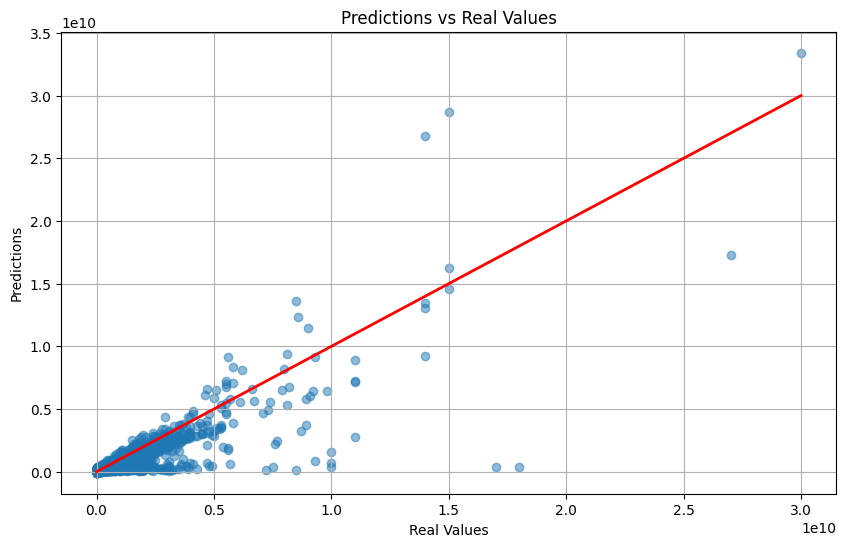

---- Validation Linear Regression ----
---- Model Linear Regression ----
Mean squared error: 2163992109675938.5000
Root mean squared error: 46518728.5905
MAE: 12066168.50004169
R2: 0.8404


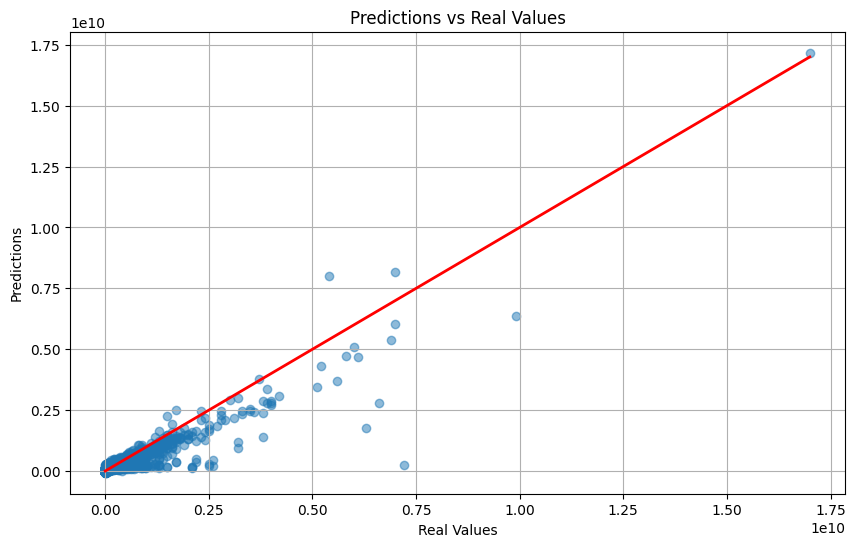

Training of LightGBM model
Training time of LightGBM: 704.05 seconds
---- Model LightGBM ----
Mean squared error: 1104069780554416.3750
Root mean squared error: 33227545.5090
MAE: 9768565.607678594
R2: 0.9222


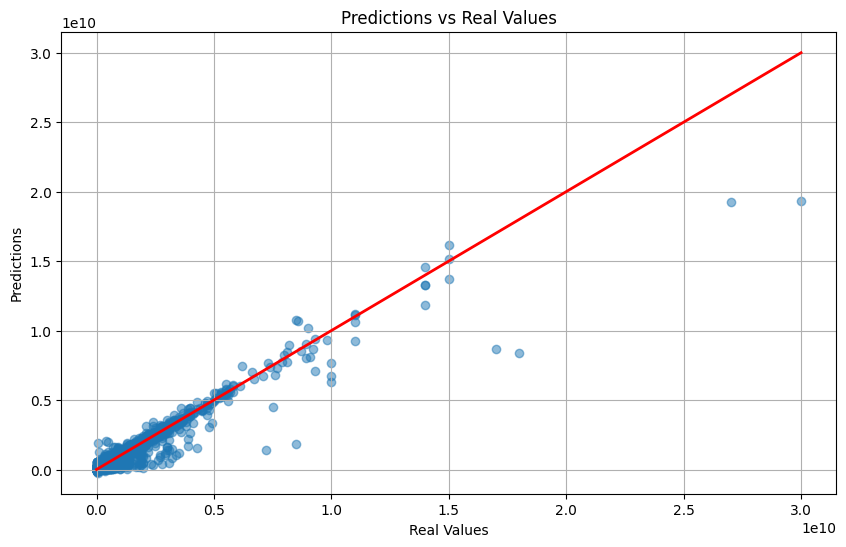

---- Validation LightGBM ----
---- Model LightGBM ----
Mean squared error: 1870815893421740.5000
Root mean squared error: 43252929.3045
MAE: 10444870.512780149
R2: 0.8620


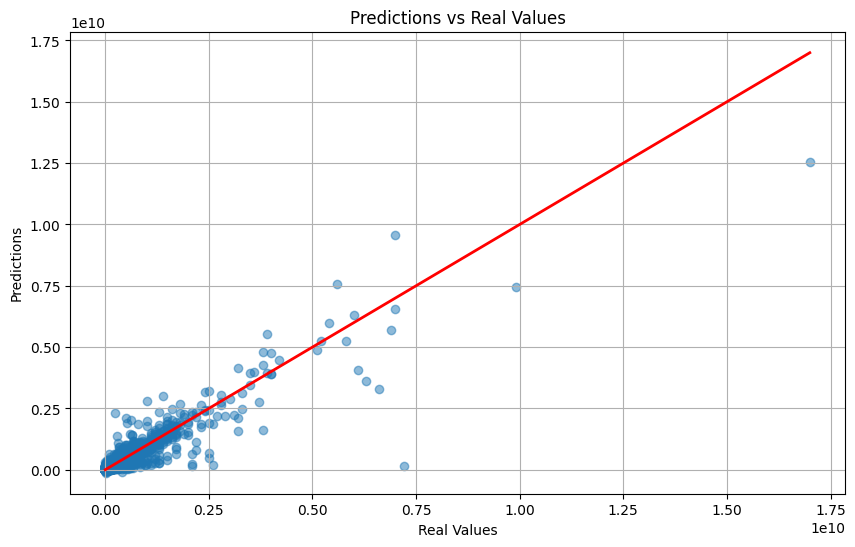

Total execution time: 12.21 mins


In [27]:
models = {
    "Linear Regression": (LinearRegression(), {}),
    #Memory issues
    #"Polynomial Regression": (Pipeline([
    #    ('poly', PolynomialFeatures()),
    #    ('linear', LinearRegression())
    #]), {
    #    'poly__degree': [ 2, 3],
    #    'linear__fit_intercept': [True, False]
    #}),
    #Too much time
    #"SVR": (SVR(), {
    #   'C': [10],
    #   'gamma': ['scale', 'auto'],
    #   'kernel': ['linear', 'rbf']
    #}),
    #Too much time
    #"Decision Tree": (DecisionTreeRegressor(random_state=42), {
    #    'max_depth': [None, 10, 20, 30],
    #    'min_samples_split': [2, 5, 10,30],
    #    'min_samples_leaf': [1, 2, 4,10]
    #}),
    "LightGBM": (LGBMRegressor(), {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [20, 40, 100],
        'verbose': [-1]
    })
    #Too much time
    #"HistGradientBoostingRegressor": (HistGradientBoostingRegressor(), {
    #    'max_iter': [100, 200],
    #    'learning_rate': [0.01, 0.1, 0.2],
    #    'max_leaf_nodes': [10, 20, None],
    #    'min_samples_leaf': [20, 50]
    #})
    
}

train_results = []
val_results = []
trained_models = {}
model_param = {}

# Train and evaluate each model
start_time = time.time()
now = datetime.now()
formatted_time = now.strftime("%H:%M:%S")

print('Current time:', formatted_time)
for name, (model, params) in models.items():
    model_start_time = time.time()
    print(f'Training of {name} model')
    if params:  # Only if there are parameters to adjust
        search = RandomizedSearchCV(model, params, n_iter=7, cv=5,
                                    random_state=42, verbose=0, scoring=['neg_root_mean_squared_error', 'r2'],
                                    refit='r2', return_train_score=True)
        #search.fit(x_train, y_train, **fit_params)
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = model.fit(x_train, y_train)

    best_params = best_model.get_params()
    model_param[name] = best_params

    train_predictions = best_model.predict(x_train)

    model_end_time = time.time()  # Time at the end of the model
    training_time = model_end_time - model_start_time  # Calculate training time

    print(f'Training time of {name}: {training_time:.2f} seconds')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_train, train_predictions)
    train_results.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    val_predictions = best_model.predict(x_val)
    
    
    print(f'---- Validation {name} ----')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_val, val_predictions)
    val_results.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    trained_models[name] = best_model  # Store the trained model
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(best_model, file)

end_time = time.time()  # Final time
total_execution_time = end_time - start_time  # Calculate total time

# Print the total execution time
print(f"Total execution time: {total_execution_time/60:.2f} mins")
# Create DataFrame of results
train_results_df = pd.DataFrame(train_results)
val_results_df = pd.DataFrame(val_results)

In [28]:
train_results_df.sort_values(by='RMSE')

,Model,RMSE,MSE,R²,MAE
1,LightGBM,3.322755e+07,1.104070e+15,0.922248,9.768566e+06
0,Linear Regression,5.907403e+07,3.489741e+15,0.754240,1.204289e+07


In [29]:
val_results_df.sort_values(by='RMSE')

,Model,RMSE,MSE,R²,MAE
1,LightGBM,4.325293e+07,1.870816e+15,0.862002,1.044487e+07
0,Linear Regression,4.651873e+07,2.163992e+15,0.840377,1.206617e+07


---- Model Linear Regression ----
Mean squared error: 2786247854341220.0000
Root mean squared error: 52784920.7098
MAE: 12050024.198640406
R2: 0.7773


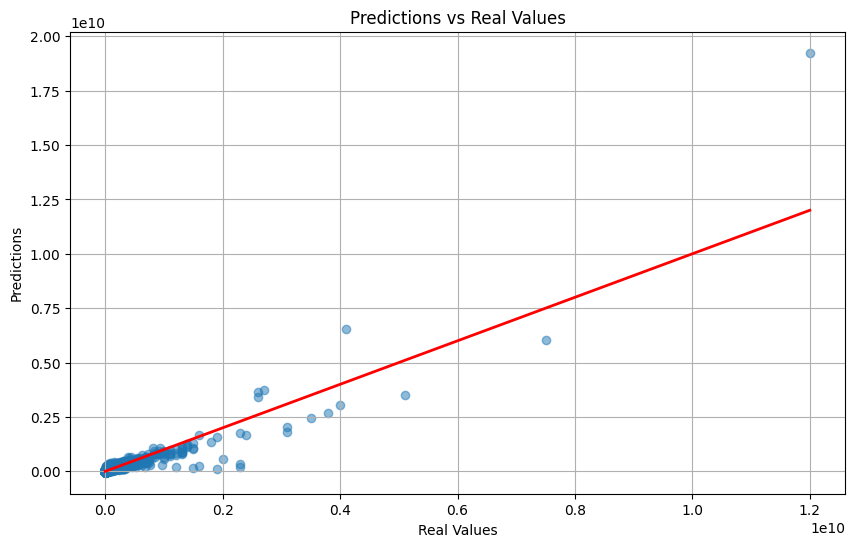

---- Model LightGBM ----
Mean squared error: 1119104431109486.1250
Root mean squared error: 33453018.2661
MAE: 10415764.644459333
R2: 0.9105


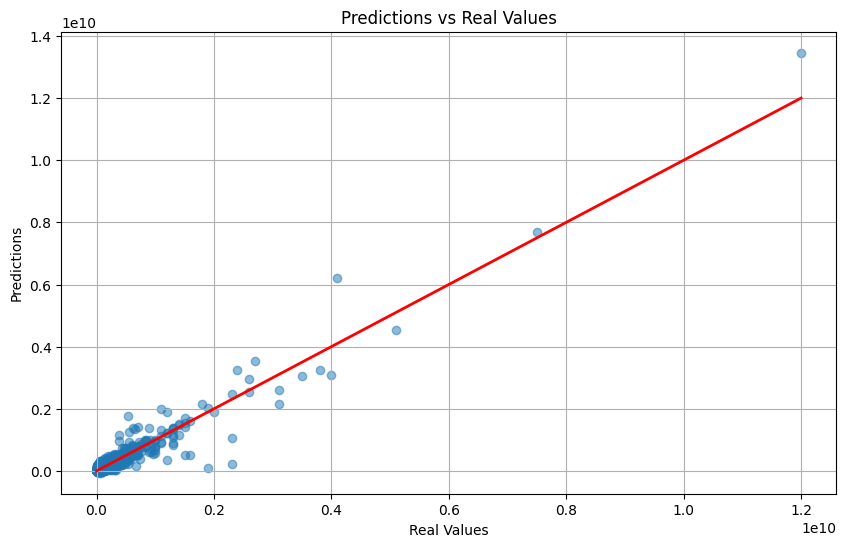

In [30]:
for name, model in trained_models.items():
    predictions = model.predict(x_test)

    # Print the training time of the model
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_test, predictions)

The LightGBM model outperforms the linear regression model both in terms of MSE and R². This suggests that for predicting "TradePrice," LightGBM captures more complexity in the data compared to linear regression. The statistics of "TradePrice" reflect a wide range and high variability, which may influence model performance and should be taken into account when interpreting results or making predictions.

In order to deal with the dispersion some models are good in that department XGBoost and CatBoost. (LightGBM parameters are added)

Current time: 00:02:52
Training of LightGBM model
Training time of LightGBM: 325.42 seconds
---- Model LightGBM ----
Mean squared error: 1775215435523600.2500
Root mean squared error: 42133305.5376
MAE: 10403552.379950885
R2: 0.8750


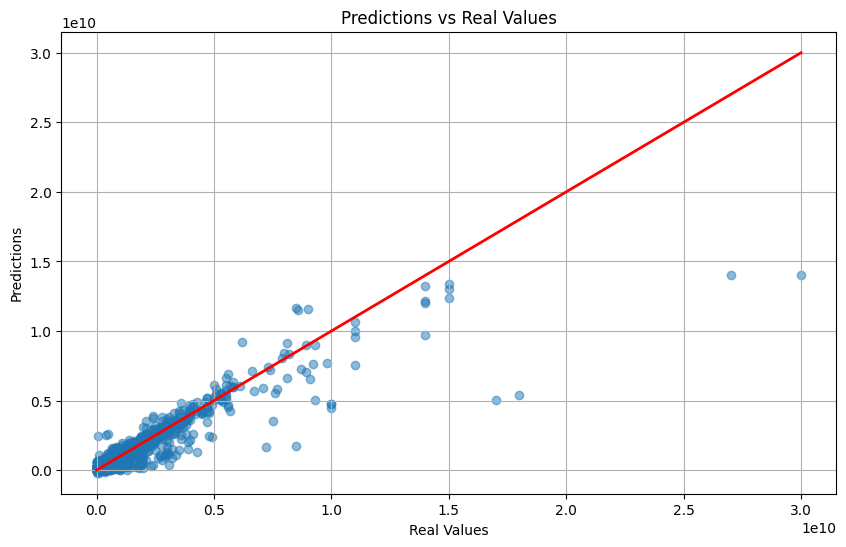

---- Validation LightGBM ----
---- Model LightGBM ----
Mean squared error: 1949107336311828.0000
Root mean squared error: 44148695.7487
MAE: 10927420.347284839
R2: 0.8562


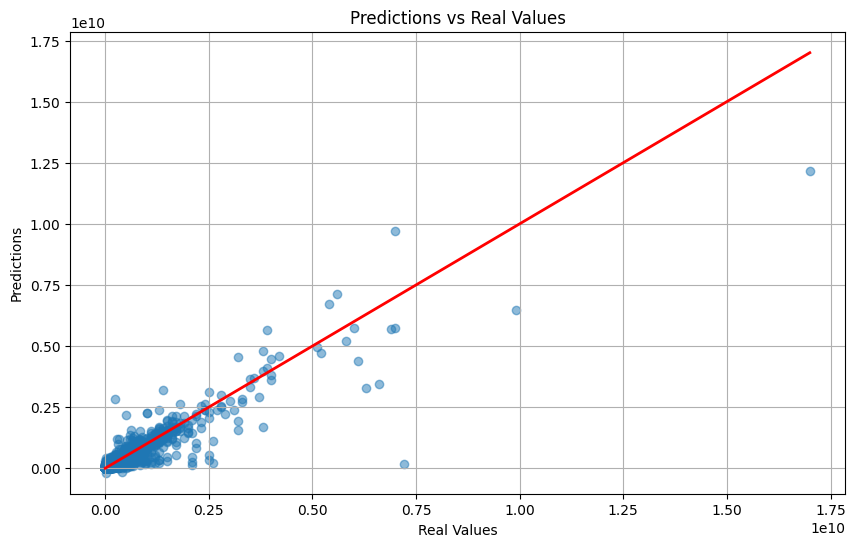

Training of XGBoost model
Training time of XGBoost: 1133.52 seconds
---- Model XGBoost ----
Mean squared error: 1071926294338917.3750
Root mean squared error: 32740285.4957
MAE: 9251339.345208757
R2: 0.9245


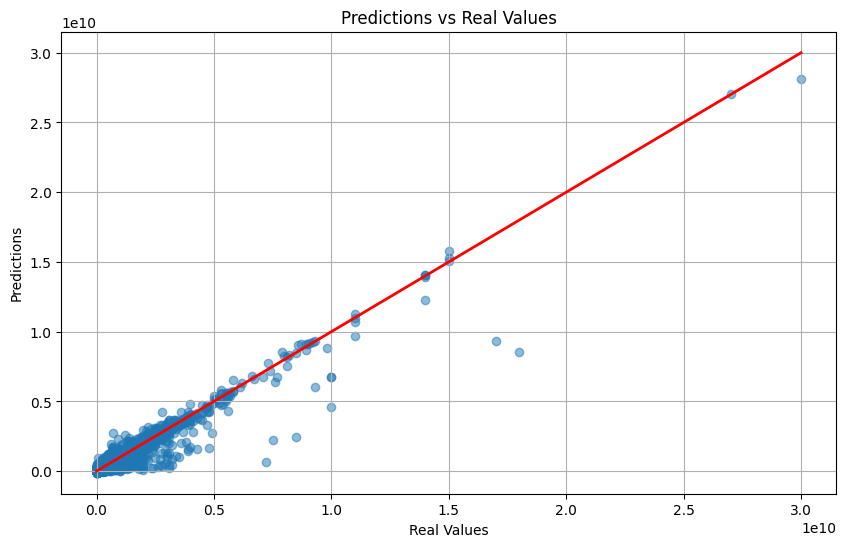

---- Validation XGBoost ----
---- Model XGBoost ----
Mean squared error: 1808669882114039.0000
Root mean squared error: 42528459.6725
MAE: 9852194.503764378
R2: 0.8666


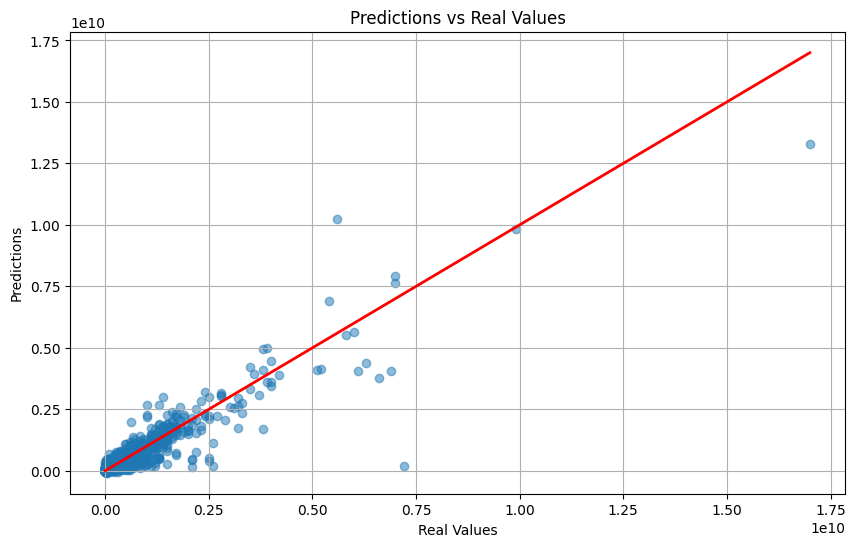

Total execution time: 24.48 mins


In [31]:
models = {
    "LightGBM": (LGBMRegressor(), {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [20, 40, 100],
        'verbose': [-1],
        'min_data_in_leaf': [20, 50],  # Added parameter to handle dispersion
        'bagging_fraction': [0.8, 1.0]   # Added parameter for data sampling
    }),
    "XGBoost": (XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=42), {
        'max_depth': [3, 5, 7],           # Controls the depth of the tree
        'learning_rate': [0.01, 0.1, 0.3], # Learning rate
        'n_estimators': [50, 100, 200],   # Number of trees to build
        'subsample': [0.8, 1.0],           # Proportion of samples to use for each tree
        'colsample_bytree': [0.8, 1.0],    # Proportion of features to use for each tree
        'reg_alpha': [0, 0.1, 1],          # L1 regularization term on weights
        'reg_lambda': [1, 10]              # L2 regularization term on weights
    })
    # Too much time 
#    "CatBoost": (CatBoostRegressor(silent=True), {
#        'depth': [6, 8, 10],               # Depth of the tree
#        'learning_rate': [0.01, 0.1, 0.5], # Learning rate
#        'iterations': [100, 200, 500],     # Number of iterations (trees)
#        'l2_leaf_reg': [3, 5, 7],          # L2 regularization on leaves
#        'bagging_temperature': [0, 1, 2]   # Temperature for data sampling
#    })
}
train_results = []
val_results = []
trained_models = {}
model_param = {}

# Train and evaluate each model
start_time = time.time()
now = datetime.now()
formatted_time = now.strftime("%H:%M:%S")

print('Current time:', formatted_time)
for name, (model, params) in models.items():
    model_start_time = time.time()
    print(f'Training of {name} model')
    if params:  # Only if there are parameters to adjust
        search = RandomizedSearchCV(model, params, n_iter=4, cv=5,
                                    random_state=42, verbose=0, scoring=['neg_root_mean_squared_error', 'r2'],
                                    refit='r2', return_train_score=True)
        #search.fit(x_train, y_train, **fit_params)
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = model.fit(x_train, y_train)

    best_params = best_model.get_params()
    model_param[name] = best_params

    train_predictions = best_model.predict(x_train)

    model_end_time = time.time()  # Time at the end of the model
    training_time = model_end_time - model_start_time  # Calculate training time

    print(f'Training time of {name}: {training_time:.2f} seconds')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_train, train_predictions)
    train_results.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    val_predictions = best_model.predict(x_val)
    
    
    print(f'---- Validation {name} ----')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_val, val_predictions)
    val_results.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    trained_models[name] = best_model  # Store the trained model
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(best_model, file)

end_time = time.time()  # Final time
total_execution_time = end_time - start_time  # Calculate total time

# Print the total execution time
print(f"Total execution time: {total_execution_time/60:.2f} mins")
# Create DataFrame of results
train_results_df = pd.DataFrame(train_results)
val_results_df = pd.DataFrame(val_results)

Testing of this models will be done at the end

Tunning hyper-parameters retrieves better performance in predictions in training and validation steps. XGBoost performed better than others and LightGBM improved results. 
One last attempt in order to deal with data dispersion and obtain better predictions is to apply log to our target variable. When the model is in production the reverse log should be applied to get real trade prices.


In [32]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test) #x+1 to avoid 0
y_val_log = np.log1p(y_val)

Current time: 00:27:21
Training of LightGBM model
Training time of LightGBM: 450.68 seconds
---- Model LightGBM ----
Mean squared error: 0.7149
Root mean squared error: 0.8455
MAE: 0.5868151510856737
R2: 0.7572


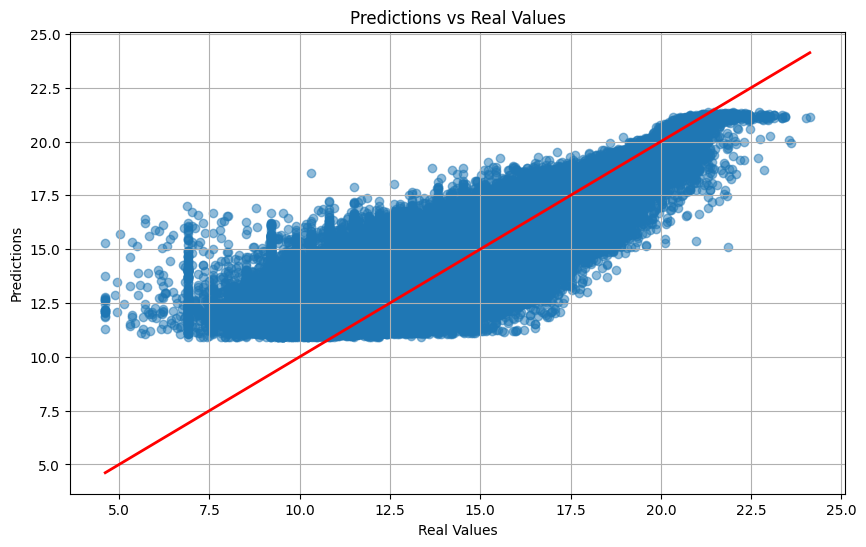

---- Validation LightGBM ----
---- Model LightGBM ----
Mean squared error: 0.7654
Root mean squared error: 0.8749
MAE: 0.6032193486853484
R2: 0.7492


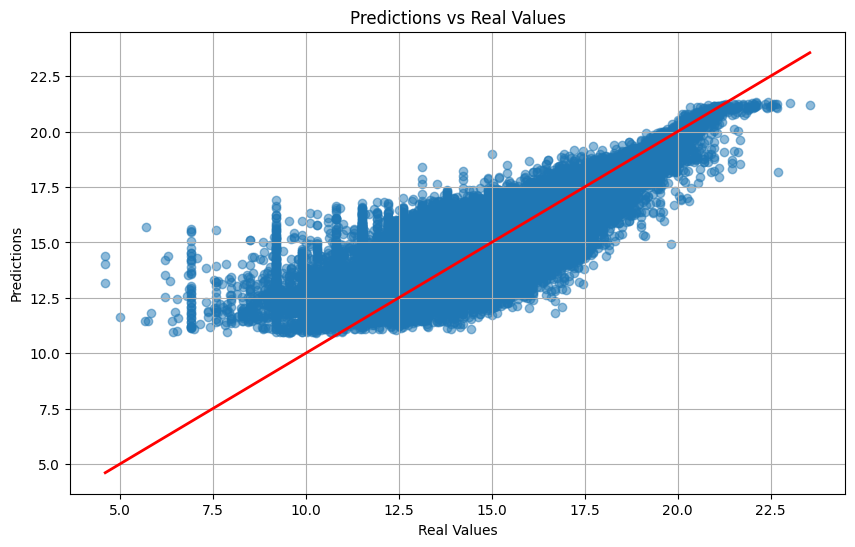

Training of XGBoost model
Training time of XGBoost: 1298.87 seconds
---- Model XGBoost ----
Mean squared error: 0.6364
Root mean squared error: 0.7978
MAE: 0.5409935377520474
R2: 0.7839


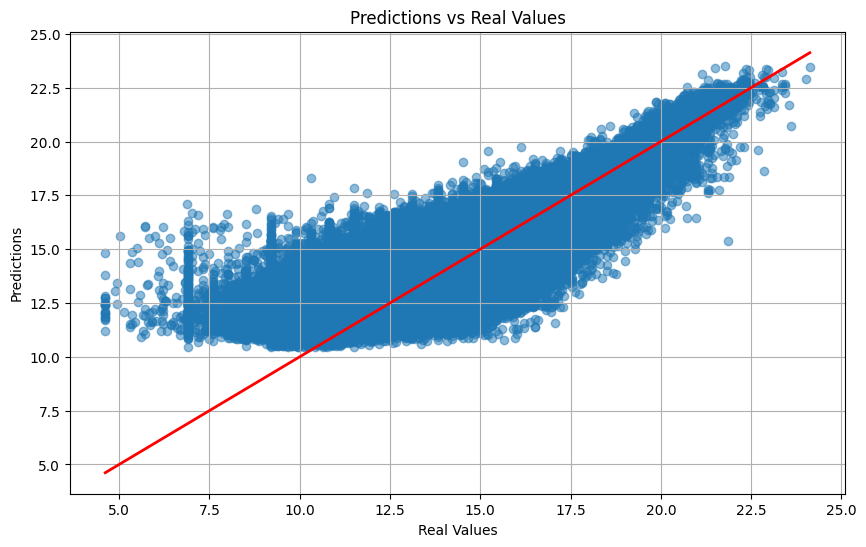

---- Validation XGBoost ----
---- Model XGBoost ----
Mean squared error: 0.6883
Root mean squared error: 0.8297
MAE: 0.5575132170347251
R2: 0.7745


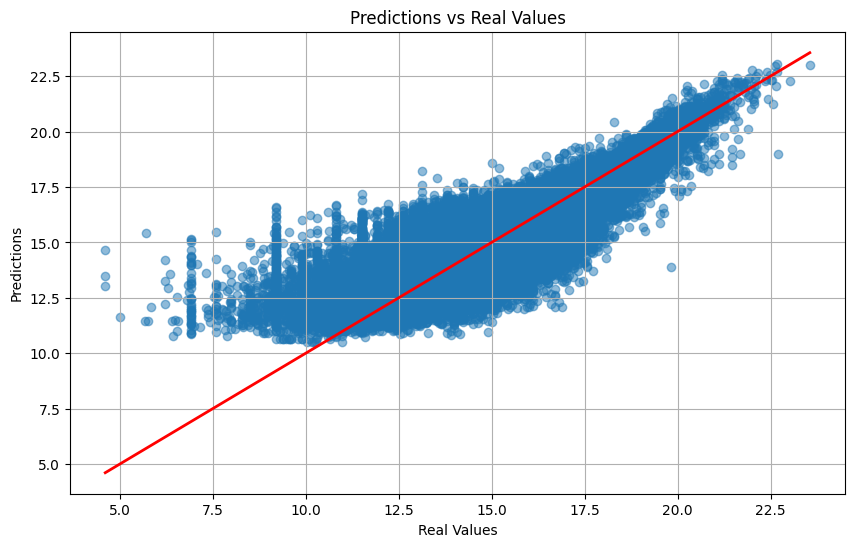

Total execution time: 29.33 mins


In [33]:
models = {
    "LightGBM": (LGBMRegressor(), {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [20, 40, 100],
        'verbose': [-1],
        'min_data_in_leaf': [20, 50],  # Added parameter to handle dispersion
        'bagging_fraction': [0.8, 1.0]   # Added parameter for data sampling
    }),
    "XGBoost": (XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=42), {
        'max_depth': [3, 5, 7],           # Controls the depth of the tree
        'learning_rate': [0.01, 0.1, 0.3], # Learning rate
        'n_estimators': [50, 100, 200],   # Number of trees to build
        'subsample': [0.8, 1.0],           # Proportion of samples to use for each tree
        'colsample_bytree': [0.8, 1.0],    # Proportion of features to use for each tree
        'reg_alpha': [0, 0.1, 1],          # L1 regularization term on weights
        'reg_lambda': [1, 10]              # L2 regularization term on weights
    })
    # Too much time 
#    "CatBoost": (CatBoostRegressor(silent=True), {
#        'depth': [6, 8, 10],               # Depth of the tree
#        'learning_rate': [0.01, 0.1, 0.5], # Learning rate
#        'iterations': [100, 200, 500],     # Number of iterations (trees)
#        'l2_leaf_reg': [3, 5, 7],          # L2 regularization on leaves
#        'bagging_temperature': [0, 1, 2]   # Temperature for data sampling
#    })
}
train_results_log = []
val_results_log = []
trained_models_log = {}
model_param_log = {}

# Train and evaluate each model
start_time = time.time()
now = datetime.now()
formatted_time = now.strftime("%H:%M:%S")

print('Current time:', formatted_time)
for name, (model, params) in models.items():
    model_start_time = time.time()
    print(f'Training of {name} model')
    if params:  # Only if there are parameters to adjust
        search = RandomizedSearchCV(model, params, n_iter=4, cv=5,
                                    random_state=42, verbose=0, scoring=['neg_root_mean_squared_error', 'r2'],
                                    refit='r2', return_train_score=True)
        #search.fit(x_train, y_train, **fit_params)
        search.fit(x_train, y_train_log)
        best_model = search.best_estimator_
    else:
        best_model = model.fit(x_train, y_train_log)

    best_params = best_model.get_params()
    model_param_log[name] = best_params

    train_predictions = best_model.predict(x_train)

    model_end_time = time.time()  # Time at the end of the model
    training_time = model_end_time - model_start_time  # Calculate training time

    print(f'Training time of {name}: {training_time:.2f} seconds')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_train_log, train_predictions)
    train_results_log.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    val_predictions = best_model.predict(x_val)
    
    
    print(f'---- Validation {name} ----')
    print(f'---- Model {name} ----')
    mse, rmse, r2, mae = get_loss(y_val_log, val_predictions)
    val_results_log.append({"Model": name,'RMSE': rmse, "MSE": mse, "R²": r2, "MAE": mae})
    
    trained_models_log[name] = best_model  # Store the trained model
    with open(f'{name}_log.pkl', 'wb') as file:
        pickle.dump(best_model, file)

end_time = time.time()  # Final time
total_execution_time = end_time - start_time  # Calculate total time

# Print the total execution time
print(f"Total execution time: {total_execution_time/60:.2f} mins")
# Create DataFrame of results
train_results_df_log = pd.DataFrame(train_results_log)
val_results_df_log = pd.DataFrame(val_results_log)

In both cases, XGBoost perform better, let's compare them. The normal one predictions will be converted (and vice versa) to log and compared.

I will use LightGBM rather than XGBoost as when I do predictions = np.log1p(predictions) I obtain NaN values that idk where they came from

In [34]:
model_log = trained_models_log["LightGBM"]
model = trained_models["LightGBM"]

In [35]:
predictions = model.predict(x_test)


In [36]:
print("LightGBM trained with normal data (in normal escale)")
predictions = model.predict(x_test)
get_loss(y_test, predictions, show=False)

LightGBM trained with normal data (in normal escale)
Mean squared error: 1160836848208893.0000
Root mean squared error: 34071055.8716
MAE: 10935547.169817412
R2: 0.9072


(1160836848208893.0, 34071055.87164702, 0.9072123578101328, 10935547.169817412)

In [37]:
predictions = np.log1p(predictions)

In [38]:
print("LightGBM trained with normal data (in log scale)")
get_loss(y_test_log, predictions, show=False)

LightGBM trained with normal data (in log scale)
Mean squared error: 1.5771
Root mean squared error: 1.2558
MAE: 0.8272313535010624
R2: 0.4493


(1.5770790702829351,
 1.2558180880537337,
 0.4492943685491346,
 0.8272313535010624)

In [39]:
predictions_log = model_log.predict(x_test)

In [40]:
print("LightGBM trained with log data (in log escale)")
get_loss(y_test_log, predictions_log, show=False)

LightGBM trained with log data (in log escale)
Mean squared error: 0.8220
Root mean squared error: 0.9067
MAE: 0.6243109818318193
R2: 0.7130


(0.8220265411835231, 0.906656793491078, 0.7129537421667593, 0.6243109818318193)

In [41]:
predicciones_orig = np.expm1(predictions_log)

In [42]:
print("LightGBM trained with log data (in normal escale)")
get_loss(y_test, predicciones_orig, show=False)

LightGBM trained with log data (in normal escale)
Mean squared error: 5845692831158738.0000
Root mean squared error: 76457130.6757
MAE: 10780833.254895704
R2: 0.5327


(5845692831158738.0, 76457130.67568478, 0.5327439376116163, 10780833.254895704)

Looking at these stats I would choose the LightGBM trained with normal data, as the one trained with log data performs worse when the log predictions are re-scaled to normal prices. There is no point in getting a model we cannot use in real cases. Actually, we should be questioning whether we want a model with good predictions (low RMS) or a nice general fit (high R2) 

The bad performance in "LightGBM trained with log data (in normal scale)" could be actually a good indicator as the high R2 value in  LightGBM trained with normal data could be caused to overfitting. (even though a test set is used)

More exploration should be done in this regard. 
- the same process could be done with the complete data set instead of only 4 years.
- I also found just now https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html that helps with target variables transformations. It can be a good step in order to check if my previous code does contain any mistakes (I am not sure if I should have also transformed training data). 
- A voting system can be useful in order to fight with overfitting and each model has it strengths and weaknesses, it averages the results to most general.
-  Models that handle nan values can be tested instead of changing the NaN by the mean. https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values.
-  Check models that can deal with categorical data without any transformation.

It was a quite interesting assigment, it was fun to do it ^^